In [1]:
# %%capture

%matplotlib widget

import time
import sys
import pickle
from threading import Thread
import ipyvolume as ipv
import numpy as np

import ipywidgets as widgets
from IPython.display import display, display_html
from IPython.display import display_javascript
from IPython.display import Image
from IPython.display import Javascript
from IPython.utils import io
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

plt.ioff()

from sample_generator import generate_sample
from calculation import calculation

import swaf
# from swaf import CoreSsh as SwafCore
from swaf import CoreBase as SwafCore

swaf_core = SwafCore(testing=False, monitoring_tool='local')
# swaf_core.set_computation_server('162.38.54.22', 'brichet', key_file='/home/brichet/projets/swaf_web/ssh_keys/id_rsa_23',
#                                  simage_file='/home/brichet/projets/swaf_web/singularity_images/lmgc90_latest')

swaf_core.allow_simultaneous_computation(3)

corrections = ""
portee_ark = 0
ark_type_global = None
pointsX_ark = {}
pointsY_ark = {}
points_X = {}
points_Y = {}

vbox = widgets.VBox([])
final_box = widgets.Box([])

def disable_calculation(e):
#     global launch_calcul
#     launch_calcul.disabled = True
    pass
    
def create_3D_figure(name, coorX, coorY):
    ipv.figure()
    cles = coorX.keys()
    for cle in cles:
        x = coorX[cle]
        y = coorY[cle]
        x_3D = np.array([[x[0], x[1]], [x[3], x[2]]])
        y_3D = np.array([[y[0], y[1]], [y[3], y[2]]])
        ipv.plot_mesh(x_3D, y_3D, np.array([[1,1],[1,1]]), surface=False)
    return ipv.gcc()
    
def fill_axis(axis, coorX, coorY, color='black'):
    cles = coorX.keys()
    for cle in cles:
        xs = coorX[cle]
        ys = coorY[cle]
        axis.plot(xs, ys, color=color)
    
def create_figure(name, coorX, coorY, color='black'):
    fig_result = plt.figure("Generated ark : {}".format(name))
    axis = fig_result.add_subplot(1, 1, 1)
    fill_axis(axis, coorX, coorY)

    axis.set_aspect('equal')
    return fig_result.canvas

def ark_generation(e):
    global portee_ark, pointsX_ark, pointsY_ark, ark_type_global, box #, launch_calcul
    
    if ark_type.value == 'Plein cintre' or  ark_type.value == 'Anse de panier':
        if fleche.value > 0.5 * portee.value:
            print('Erreur : fleche de la voute trop importante pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.5 * portee.value
        elif fleche.value < 0.2 * portee.value:
            print('Erreur : fleche de la voute trop faible pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.2 * portee.value
    elif ark_type.value == 'Parabole':
        if fleche.value < 0.2 * portee.value:
            print('Erreur : fleche de la voute trop faible pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.2 * portee.value
    elif ark_type.value == 'Ogive':
        if fleche.value < 0.5 * portee.value:
            print('Erreur : fleche de la voute trop faible pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.5 * portee.value
    ark_parameters = {"portee0": portee.value, 
                      "fleche0": fleche.value, 
                      "ep_bandeau0": ep_bandeau.value, 
                      "ep_rein0": ep_rein.value, 
                      "Lc_blocs0": lc_blocs.value, 
                      "bandeau_type0":bandeau_type.value, 
                      "ancrage0": ancrage.value, 
                      "Umas_bloc0": umas_bloc.value, 
                      "Rc_bloc0": rc_bloc.value, 
                      "mortar_type0":mortar_type.value,
                      "lambda_u0": lambda_u.value,
                      "h_remblais0": h_remblais.value,
                      "rho_remblais0": rho_remblais.value}
    
    with io.capture_output() as captured:
        points_X, points_Y = generate_sample(ark_type.value, ark_parameters);
    
    portee_ark = portee.value
    pointsX_ark = points_X
    pointsY_ark = points_Y
    ark_type_global = ark_type.value
    
    
#     create_figure(ark_type.value, points_X, points_Y)
    vbox.children = (create_3D_figure(ark_type.value, points_X, points_Y), )
#     vbox.children = (create_figure(ark_type.value, points_X, points_Y), 
#                      create_3D_figure(ark_type.value, points_X, points_Y))
    
#     launch_calcul.disabled = False
    
def execute_calculation(e):
    Q=[]
    if v1.value > 0.1 :
        Q.append((v1.value, e1.value*portee_ark - portee_ark*0.5))
    if v2.value > 0.1 :
        Q.append((v2.value, e2.value*portee_ark - portee_ark*0.5))
    if v3.value > 0.1 :
        Q.append((v3.value, e3.value*portee_ark - portee_ark*0.5))
    load_parameters = {"chargeV1_0": v1.value,
                       "chargeV2_0": v2.value,
                       "chargeV3_0": v3.value,
                       "ecc_e1_0": e1.value,
                       "ecc_e2_0": e2.value,
                       "ecc_e3_0": e3.value,
                       "Q": Q}
    swaf_core.compute(calculation, load_parameters=load_parameters)
    monitor_calculation()

def monitor_calculation():
    global points_X, points_Y, final_box
    print("monitoring launched")
    state = "Calculs en cours"
#     calculation_state.value = state
#     while not swaf_core.monitors[0].computation_over:
#         if swaf_core.monitors[0].queue_status.empty():
#             time.sleep(0.01)
#         else:
#             state, progress = swaf_core.monitors[0].queue_status.get()
#             calculation_state.value = state
#             calculation_progress.value = progress
    
#     while not swaf_core.monitors[0].queue_status.empty():
#         state, progress = swaf_core.monitors[0].queue_status.get()
#         calculation_state.value = state
#         calculation_progress.value = progress
    
    points_X, points_Y = swaf_core.monitors[0].get_final_data()

    fig_result_final = plt.figure("Calculated ark : {}".format(ark_type_global))
    axis = fig_result_final.add_subplot(1, 1, 1)
    fill_axis(axis, pointsX_ark, pointsY_ark)
    fill_axis(axis, points_X, points_Y, color='red')
    axis.set_aspect('equal')
    final_box.children = (fig_result_final.canvas, )

Info : gmshutils module not available
Info : med file reading module not available


# Arch 2D description

## Géométrie

In [2]:
ark_type = widgets.RadioButtons(
    options=['PC', 'AP', 'Og', 'Par'],
    value='Og',
    description='Type d\'arche:',
    disabled=False
)
ark_type.observe(disable_calculation, names='value')

portee = widgets.BoundedFloatText(
    value=2.0,
    min=0,
    max=100,
    step=0.1,
    disabled=False,
    description="\t\t",
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='f'
)
portee.observe(disable_calculation, names='value')

fleche = widgets.BoundedFloatText(
    value=1.0,
    min=0,
    max=100,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
fleche.observe(disable_calculation, names='value')

ep_bandeau = widgets.BoundedFloatText(
    value=0.2,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
ep_bandeau.observe(disable_calculation, names='value')

ep_rein = widgets.BoundedFloatText(
    value=0.2,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
ep_rein.observe(disable_calculation, names='value')

lc_blocs = widgets.BoundedFloatText(
    value=0.3,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
lc_blocs.observe(disable_calculation, names='value')

bandeau_type = widgets.RadioButtons(
    options=['BS', 'H', 'TC'],
    value='BS',
    description='\t',
    disabled=False,
)
bandeau_type.observe(disable_calculation, names='value')

ancrage = widgets.BoundedFloatText(
    value=0.1,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
ancrage.observe(disable_calculation, names='value')

display(ark_type)
print("\nPorteeFlech f (en m) : ")
display(portee)
print("\nFleche f (en m) : ")
display(fleche)
print("\nEpaisseur du bandeau b (en m) : ")
display(ep_bandeau)
print("\nEpaisseur des reins r (en m) : ")
display(ep_rein)
print("\nLongueur caracteristique des blocs lc (en m) :")
display(lc_blocs)
print("\nType de bandeau : ")
display(bandeau_type)
print("\nLongueur d'ancrage du harpage a (en m) :")
display(ancrage)

RadioButtons(description="Type d'arche:", index=2, options=('PC', 'AP', 'Og', 'Par'), value='Og')


PorteeFlech f (en m) : 


BoundedFloatText(value=2.0, description='\t\t', step=0.1)


Fleche f (en m) : 


BoundedFloatText(value=1.0, description='\t\t', step=0.1)


Epaisseur du bandeau b (en m) : 


BoundedFloatText(value=0.2, description='\t\t', max=1.0, step=0.1)


Epaisseur des reins r (en m) : 


BoundedFloatText(value=0.2, description='\t\t', max=1.0, step=0.1)


Longueur caracteristique des blocs lc (en m) :


BoundedFloatText(value=0.3, description='\t\t', max=1.0, step=0.1)


Type de bandeau : 


RadioButtons(description='\t', options=('BS', 'H', 'TC'), value='BS')


Longueur d'ancrage du harpage a (en m) :


BoundedFloatText(value=0.1, description='\t\t', max=1.0, step=0.1)

## Matériaux

### Blocs

In [3]:
umas_bloc = widgets.FloatText(
    value=1200.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
umas_bloc.observe(disable_calculation, names='value')

rc_bloc = widgets.FloatText(
    value=53.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
rc_bloc.observe(disable_calculation, names='value')

print("Masse volumique ρb (en kg.m-3) :")
display(umas_bloc)
print("Resistance a la compression Rc (en MPa) :")
display(rc_bloc)


Masse volumique ρb (en kg.m-3) :


FloatText(value=1200.0, description='\t\t', step=0.1)

Resistance a la compression Rc (en MPa) :


FloatText(value=53.0, description='\t\t', step=0.1)

### Mortier

In [4]:
mortar_type = widgets.RadioButtons(
    options=['M0', 'M1', 'M2', 'M3', 'M4'],
    value='M0',
    description='\t',
    disabled=False
)
mortar_type.observe(disable_calculation, names='value')

print("Type de mortier :")
display(mortar_type)


Type de mortier :


RadioButtons(description='\t', options=('M0', 'M1', 'M2', 'M3', 'M4'), value='M0')

## Chargement

### Charges permanentes

In [5]:
lambda_u = widgets.FloatText(
    value=2200.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
lambda_u.observe(disable_calculation, names='value')

h_remblais = widgets.FloatText(
    value=0.3,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
h_remblais.observe(disable_calculation, names='value')

rho_remblais = widgets.FloatText(
    value=1800.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
rho_remblais.observe(disable_calculation, names='value')

print("Charge surfacique utile λu (en kN/m2) :")
display(lambda_u)
print("Epaisseur remblais hr (en m) :")
display(h_remblais)
print("Charge remblais ρr (en kN/m3) :")
display(rho_remblais)


Charge surfacique utile λu (en kN/m2) :


FloatText(value=2200.0, description='\t\t', step=0.1)

Epaisseur remblais hr (en m) :


FloatText(value=0.3, description='\t\t', step=0.1)

Charge remblais ρr (en kN/m3) :


FloatText(value=1800.0, description='\t\t', step=0.1)

### Charges ponctuelles

In [6]:
v1 = widgets.FloatText(
    value=1000.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

v2 = widgets.FloatText(
    value=2000,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

v3 = widgets.FloatText(
    value=3000.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

e1 = widgets.FloatText(
    value=0.1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

e2 = widgets.FloatText(
    value=0.2,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

e3 = widgets.FloatText(
    value=0.3,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

print("Charge ponctuelle V1 (en kN) :")
display(v1)
print("Charge ponctuelle V2 (en kN) :")
display(v2)
print("Charge ponctuelle V3 (en kN) :")
display(v3)
print("Position de la charge V1 : e1 (en m) :")
display(e1)
print("Position de la charge V2 : e2 (en m) :")
display(e2)
print("Position de la charge V3 : e3 (en m) :")
display(e3)


Charge ponctuelle V1 (en kN) :


FloatText(value=1000.0, description='\t\t', step=0.1)

Charge ponctuelle V2 (en kN) :


FloatText(value=2000.0, description='\t\t', step=0.1)

Charge ponctuelle V3 (en kN) :


FloatText(value=3000.0, description='\t\t', step=0.1)

Position de la charge V1 : e1 (en m) :


FloatText(value=0.1, description='\t\t', step=0.1)

Position de la charge V2 : e2 (en m) :


FloatText(value=0.2, description='\t\t', step=0.1)

Position de la charge V3 : e3 (en m) :


FloatText(value=0.3, description='\t\t', step=0.1)

Schéma explicatif des éléments d'une arche : 


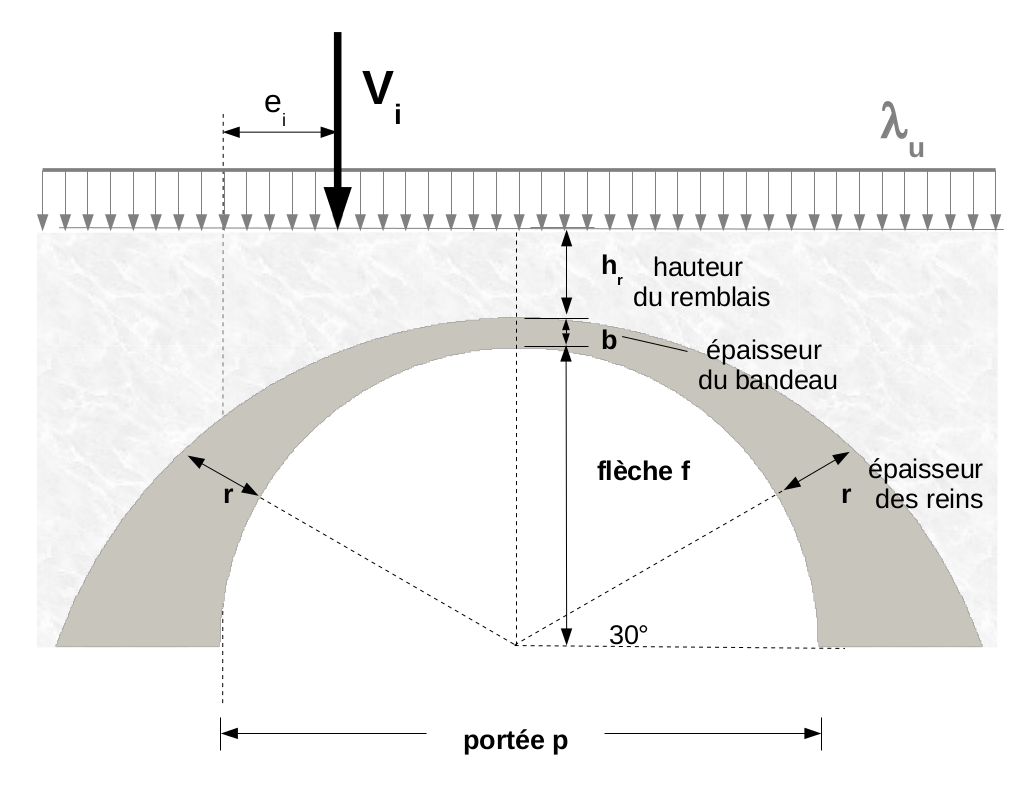

In [7]:
print("Schéma explicatif des éléments d'une arche : ")
Image(filename='img/description_arches_2D.png')

In [8]:
launch_ark = widgets.Button(
    description='Générer l\'arche',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)
display(launch_ark)
launch_ark.on_click(ark_generation)

vbox

Button(button_style='success', description="Générer l'arche", style=ButtonStyle(), tooltip='Click me')

VBox()

In [9]:
# launch_calcul = widgets.Button(
#     description='Calculs',
#     disabled=True,
#     button_style='success', # 'success', 'info', 'warning', 'danger' or ''
#     tooltip='Click me',
# )
# display(launch_calcul)
# launch_calcul.on_click(execute_calculation)

swaf_core.display_compute_widget(execute_calculation, vertical=True)

# calculation_state = widgets.Label(value="Waiting for calculation...")
# display(calculation_state)

# calculation_progress = widgets.IntProgress(
#     value=0,
#     min=0,
#     max=100,
# )
# display(calculation_progress)

final_box


Box()

command : /home/nico/miniconda3/envs/swaf/bin/python /tmp/swaf_client_slsev_s7/arches_2020-09-04_13-22-50.399/encapsulate.py
Command executed
monitors appended
callback set up
monitoring launched


In [10]:
swaf_core.monitors


[]

In [11]:
# calculation_state = widgets.Label(value="Waiting for calculation...")

# calculation_progress = widgets.IntProgress(
#     value=0,
#     min=0,
#     max=100,
# )

# a = widgets.VBox([calculation_state, calculation_progress], layout=widgets.Layout(border='solid 1px'))
# display(a)

In [12]:
# display(HTML("""
# <div id='swaf_log_1' style='position:absolute;background-color:white;'>
# tralala
# </div>
# """))

In [13]:
# display(HTML("""
# <script>
#     $('#swaf_log_1').show();
# </script>
# """))